## **P2: Importing Dataset & Data Wrangling**

Using GEO ((Gene Expression Omnibus) dataset GSE13164 for leukemia diagnosis, includes:
- Downloading and parsing GEO series data
- Extracting and filtering labels
- Merging sample expression data
- Mapping probes to gene accessions
- Aligning and encoding the final dataset

### **Import Required Libraries**

Load all necessary libraries for data processing:
- **GEOparse**: To access to sample metadata, expression data, and platform information.
- **pandas (pd)**: To create DataFrames, merge tables, and handle CSV input/output.
- **numpy (np)**: For array operations and mathematical functions.
- **LabelEncoder (from sklearn.preprocessing)**: To convert categorical labels (leukemia types) into numeric codes for machine learning models.
- **re**: To identify leukemia types in sample characteristics using regex search.
- **os**: To create directories and manage file paths.
- **reduce (from functools)**: To merge multiple DataFrames sequentially.

In [1]:
import GEOparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re 
import os 
from functools import reduce

### **Configuration and Constants**
Set up configuration parameters including the GEO dataset ID, output file names, target disease classes, and feature identifier column.

In [2]:
# configuration
GSE_ID = "GSE13164" 
OUTPUT_CLEAN_DATA = "GSE13164_cleaned_features.csv"
OUTPUT_CLEAN_LABELS = "GSE13164_cleaned_labels.csv"

# constants
TARGET_CLASSES = ['ALL', 'AML', 'CLL', 'CML']
FEATURE_IDENTIFIER = 'GB_ACC'

### **Download and Parse GEO Data**

Downloads the GEO dataset using GEOparse and extracts the platform (GPL) annotation table. Returns both the GEO object (containing sample data) and the platform table (containing probe annotations).

In [3]:
def download_and_parse_geo(gse_id):
    print(f"Downloading and parsing GEO series: {gse_id}...")
    print(f"Current working directory: {os.getcwd()}")
    
    try:
        # Try to load from local Raw Data folder first if it exists
        local_file = f"./Raw Data/{gse_id}_family.soft.gz"
        print(f"Checking for local file at: {local_file}")
        print(f"Local file exists: {os.path.exists(local_file)}")
        
        if os.path.exists(local_file):
            print(f"Loading GEO data from local file: {local_file}")
            gse = GEOparse.get_GEO(filepath=local_file, silent=False)
        else:
            print(f"Local file not found, attempting FTP download...")
            gse = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=False)
    except Exception as e:
        print(f"Error downloading/parsing {gse_id}: {e}")
        return None, None
    
    platform_key = list(gse.gpls.keys())[0]
    gpl_table = gse.gpls[platform_key].table.copy()
    
    return gse, gpl_table

### **Extract and Filter Samples**
Iterates through all samples in the GEO dataset and:
- Extracts leukemia type labels from sample characteristics
- Filters for only target classes (ALL, AML, CLL, CML)
- Extracts expression values for valid samples
- Returns filtered sample DataFrames and metadata

In [4]:
def extract_and_filter_samples(gse):
    metadata_list = []
    sample_dfs = []

    for name, gsm in gse.gsms.items():
        characteristics = ' '.join(gsm.metadata.get('characteristics_ch1', ['']))
        leukemia_type = None
        
        # identify leukemia type based on target classes
        for t_type in TARGET_CLASSES:
            if re.search(r'\b' + re.escape(t_type) + r'\b', characteristics, re.IGNORECASE):
                leukemia_type = t_type
                break

        # only process samples belonging to target classes
        if leukemia_type in TARGET_CLASSES:
            metadata_list.append({'Sample_ID': name, 'Leukemia_Type': leukemia_type})
            
            # extract expression data
            gsm_df = gsm.table.copy()
            
            if 'ID_REF' not in gsm_df.columns:
                print(f"Warning: GSM {name} missing 'ID_REF'. Skipping.")
                continue
            
            # identify expression val col
            value_col = next((col for col in gsm_df.columns if col.upper() in ['VALUE', 'LOG_RATIO', 'SIGNAL', 'AVG_SIGNAL', 'NORMALIZED_SIGNAL']), None)
            
            if not value_col:
                non_id_cols = [c for c in gsm_df.columns if c != 'ID_REF']
                if non_id_cols:
                    value_col = non_id_cols[-1]
                else:
                    print(f"Warning: GSM {name} has no detectable value column. Skipping.")
                    continue

            gsm_df = gsm_df[['ID_REF', value_col]].rename(columns={value_col: name})
            sample_dfs.append(gsm_df)

    metadata_df = pd.DataFrame(metadata_list)
    print(f"Samples identified and labeled: {len(sample_dfs)}.")
    
    return sample_dfs, metadata_df

### **Merge Expression Data**
Combines all individual sample DataFrames into a single expression matrix by merging on probe ID (ID_REF). Uses an inner join to retain only probes that are present in all samples.

In [5]:
def merge_expression_data(sample_dfs):
    expression_data = reduce(lambda left, right: pd.merge(left, right, on='ID_REF', how='inner'), sample_dfs)
    expression_data = expression_data.set_index('ID_REF')
    
    print(f"Initial Merged Feature Matrix Shape (Probes x Samples): {expression_data.shape}")
    
    return expression_data

### **Annotate and Aggregate Features**
Maps probes to gene accessions using the platform annotation table and aggregates expression values by gene:
- Extracts and cleans feature IDs (gene accessions) from platform data
- Merges annotation with expression data
- Groups by gene and computes mean expression across probes
- Transposes to create a sample × gene feature matrix

In [6]:
def annotate_and_aggregate_features(expression_data, gpl_table):
    # extract annotation information from platform table
    annotation_cols = ['ID', FEATURE_IDENTIFIER]
    annotation_df = gpl_table[annotation_cols].rename(columns={'ID': 'ID_REF', FEATURE_IDENTIFIER: 'Feature_ID'})

    # clean feature IDs
    annotation_df.dropna(subset=['Feature_ID'], inplace=True)
    annotation_df = annotation_df[annotation_df['Feature_ID'].str.strip() != '---']
    annotation_df['Feature_ID'] = annotation_df['Feature_ID'].apply(lambda x: x.split(' // ')[0].strip())
    
    # merge annotation with expression data
    merged_df = pd.merge(expression_data.reset_index(), annotation_df, on='ID_REF', how='inner')
    merged_df.dropna(subset=['Feature_ID'], inplace=True)
    
    # get sample cols & aggregate by gene
    sample_cols = [col for col in merged_df.columns if col.startswith('GSM')]
    final_features_df = merged_df.groupby('Feature_ID')[sample_cols].mean()
    
    # transpose, samples as rows, features as cols
    final_features_df = final_features_df.T
    
    return final_features_df

### **Align and Encode Labels**
Prepares the final dataset by:
- Aligning metadata with the feature matrix using sample IDs
- Encoding categorical leukemia types to numeric codes (0, 1, 2, 3)
- Verifying sample-wise alignment between features and labels

In [7]:
def align_and_encode_labels(final_features_df, metadata_df):
    # align metadata with sample id
    metadata_df = metadata_df.set_index('Sample_ID').loc[final_features_df.index.tolist()].reset_index()

    # encode target labels
    le = LabelEncoder()
    metadata_df['Target_Code'] = le.fit_transform(metadata_df['Leukemia_Type'])

    # final alignment check
    print("\n--- Final Data Alignment ---")
    print(f"Final Feature Matrix Shape (Samples x Features): {final_features_df.shape}")
    print(f"Final Label Matrix Shape (Samples x Info): {metadata_df.shape}")
    print(f"Sample-wise alignment check (should be TRUE): {all(final_features_df.index == metadata_df['Sample_ID'])}")

    return final_features_df, metadata_df

### **Functions Calling**
Coordinates the entire data processing pipeline (from 3-7) by calling each helper function in sequence.

In [8]:
def load_and_preprocess_geo(gse_id):
    # 3. download & parse
    gse, gpl_table = download_and_parse_geo(gse_id)
    if gse is None:
        return None, None
    
    #4. extract & filter samples
    sample_dfs, metadata_df = extract_and_filter_samples(gse)
    if sample_dfs is None:
        return None, None
    
    # 5. merge expression data
    expression_data = merge_expression_data(sample_dfs)
    
    # 6. annotate & aggregate
    final_features_df = annotate_and_aggregate_features(expression_data, gpl_table)
    
    # 7. align & encode
    final_features_df, metadata_df = align_and_encode_labels(final_features_df, metadata_df)
    
    return final_features_df, metadata_df

### **Data Processing and Export**
Execute the main pipeline:
- Create output directory for processed data
- Run the complete GEO data processing function
- Save cleaned features and labels to CSV files

In [9]:
# create data directory
os.makedirs('data', exist_ok=True)

print("--- Starting O1: Data Collection & Wrangling (Python) ---")
# load, clean & map the data
expression_data, metadata = load_and_preprocess_geo(GSE_ID)

if expression_data is not None and metadata is not None:
    try:
        # save the final products for next step
        expression_data.to_csv(OUTPUT_CLEAN_DATA)
        metadata.to_csv(OUTPUT_CLEAN_LABELS, index=False)
        print(f"\nSUCCESS: Cleaned features saved to: {OUTPUT_CLEAN_DATA}")
        print(f"SUCCESS: Cleaned labels saved to: {OUTPUT_CLEAN_LABELS}")
    except Exception as e:
        print(f"Error saving data: {e}")

    print("Data Wrangling (O1) is now complete.")

17-Jan-2026 21:01:59 INFO GEOparse - Parsing ./Raw Data/GSE13164_family.soft.gz: 
17-Jan-2026 21:01:59 DEBUG GEOparse - DATABASE: GeoMiame
17-Jan-2026 21:01:59 DEBUG GEOparse - SERIES: GSE13164
17-Jan-2026 21:01:59 DEBUG GEOparse - PLATFORM: GPL7473
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331733
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331734
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331735
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331736
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331737
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331738
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331739
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331740
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331741
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331742
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331743
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331744
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331745
17-Jan-2026 21:01:59 D

--- Starting O1: Data Collection & Wrangling (Python) ---
Current working directory: /Users/nguyuling/Leukemia-Diagnosis
Checking for local file at: ./Raw Data/GSE13164_family.soft.gz
Local file exists: True
Loading GEO data from local file: ./Raw Data/GSE13164_family.soft.gz


17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331827
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331828
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331829
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331830
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331831
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331832
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331833
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331834
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331835
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331836
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331837
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331838
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331839
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331840
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331841
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331842
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GSM331843
17-Jan-2026 21:01:59 DEBUG GEOparse - SAMPLE: GS

Samples identified and labeled: 973.
Initial Merged Feature Matrix Shape (Probes x Samples): (1480, 973)

--- Final Data Alignment ---
Final Feature Matrix Shape (Samples x Features): (973, 1420)
Final Label Matrix Shape (Samples x Info): (973, 3)
Sample-wise alignment check (should be TRUE): True

SUCCESS: Cleaned features saved to: GSE13164_cleaned_features.csv
SUCCESS: Cleaned labels saved to: GSE13164_cleaned_labels.csv
Data Wrangling (O1) is now complete.


## **P3 - Exploratory Data Analysis**

Performing exploratory data analysis on the processed leukemia gene expression dataset, includes:
- Loading and combining cleaned features and labels
- Computing descriptive statistics
- Grouping analysis by leukemia type
- ANOVA testing for significant gene expression differences
- Correlation analysis between genes

### **Import Required Libraries**
Load all necessary libraries for data analysis, visualization, and statistical testing.

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 10)

### **Load and Combine Data**

Load the cleaned feature matrix and labels from the data wrangling step. Combine them into a single dataframe with samples as rows and gene expression values as columns, aligned by Sample_ID.

In [11]:
# load the 2 cleaned csv files
features_df = pd.read_csv('GSE13164_cleaned_features.csv', index_col=0)
labels_df = pd.read_csv('GSE13164_cleaned_labels.csv')

# align & combine: Sample_ID | Leukemia_Type | Gene1 ... geneN
combined_df = (
    labels_df[['Sample_ID', 'Leukemia_Type']]
    .set_index('Sample_ID')
    .join(features_df, how='inner')
    .reset_index()
)

combined_df = combined_df[['Sample_ID', 'Leukemia_Type'] + [c for c in combined_df.columns if c not in ['Sample_ID', 'Leukemia_Type']]]
gene_expression = combined_df.drop(columns=['Sample_ID', 'Leukemia_Type'])
leukemia_types = combined_df['Leukemia_Type']

print(f"Combined dataset shape: {combined_df.shape}")
print(f"Gene Expression dataset shape: {gene_expression.shape}")

Combined dataset shape: (973, 1422)
Gene Expression dataset shape: (973, 1420)


### **Basic Data Overview**
Display basic information about the dataset including shape, dimensions, and sample rows to verify data integrity and structure.

In [12]:
print(f"Dataset Shape: {combined_df.shape}")
print(f"Columns: Sample_ID, Leukemia_Type, {combined_df.shape[1]-2} genes")

Dataset Shape: (973, 1422)
Columns: Sample_ID, Leukemia_Type, 1420 genes


In [13]:
print("First 5 rows (first 10 columns):")
combined_df.head(5)

First 5 rows (first 10 columns):


,Sample_ID,Leukemia_Type,AA022668,AA045174,AA045184,...,X95660,Y00062,Z22969,Z25521,Z49258
0,GSM331733,ALL,0.021524,0.313375,0.621374,...,0.147316,0.652401,0.251543,0.542704,0.034048
1,GSM331735,ALL,0.138425,0.367138,0.209544,...,0.161024,0.643809,0.166796,0.470802,0.048288
2,GSM331736,ALL,0.166461,0.353492,0.584845,...,0.100688,0.548033,0.100538,0.508992,0.076684
3,GSM331737,ALL,0.119696,0.390152,0.206351,...,0.079367,0.780182,0.147899,0.711219,0.036944
4,GSM331739,ALL,0.072855,0.344026,0.110417,...,0.125102,0.561885,0.119055,0.479710,0.075409


In [14]:
print("Last 5 rows (excluding last gene column):")
combined_df.tail(5)

Last 5 rows (excluding last gene column):


,Sample_ID,Leukemia_Type,AA022668,AA045174,AA045184,...,X95660,Y00062,Z22969,Z25521,Z49258
968,GSM332879,CLL,0.126125,0.457595,0.182019,...,0.140510,0.741261,0.345432,0.590160,0.139727
969,GSM332880,AML,0.008868,0.451833,0.218862,...,0.115515,0.719811,0.017433,0.623884,0.233855
970,GSM332881,ALL,0.046805,0.324388,0.251160,...,0.090959,0.509765,0.197561,0.411354,0.058076
971,GSM332882,AML,0.063562,0.397079,0.223211,...,0.157383,0.606927,0.047135,0.542704,0.064848
972,GSM332883,CLL,0.038635,0.585898,0.226493,...,0.200107,0.738707,0.146915,0.535772,0.115851


### **Descriptive Statistics**
Compute and display summary statistics (mean, std, min, max...) for gene expression data both overall and stratified by leukemia type.

In [15]:
print("Overall gene expression statistics:")
gene_expression.describe()

Overall gene expression statistics:


,AA022668,AA045174,AA045184,AA054642,AA058578,...,X95660,Y00062,Z22969,Z25521,Z49258
count,973.000000,973.000000,973.000000,973.000000,973.000000,...,973.000000,973.000000,973.000000,973.000000,973.000000
mean,0.075085,0.380579,0.329312,0.184106,0.371812,...,0.139644,0.665124,0.204221,0.550737,0.112663
std,0.076518,0.092361,0.186626,0.114658,0.081254,...,0.036342,0.095544,0.148617,0.054515,0.079998
min,0.000000,0.029028,0.024423,0.000000,0.044819,...,0.011156,0.324388,0.000000,0.326625,0.000000
25%,0.024423,0.321276,0.201414,0.089093,0.316431,...,0.115329,0.612824,0.087186,0.516030,0.058723
50%,0.053365,0.370126,0.257699,0.166126,0.356376,...,0.137917,0.691644,0.165457,0.548033,0.097993
75%,0.098629,0.440007,0.432756,0.266284,0.419293,...,0.163679,0.733738,0.304334,0.581717,0.148228
max,0.558113,0.615230,0.770034,0.609266,0.608093,...,0.274818,0.828838,0.776699,0.749232,0.757725


In [16]:
# Descriptive Statistics by Leukemia Type (first 6 genes)

for ltype in ['ALL', 'AML', 'CLL', 'CML']:
    print(f"\n{ltype} (n={(leukemia_types == ltype).sum()}):")
    print(gene_expression[leukemia_types == ltype].describe().loc[['mean', 'std', 'min', 'max']].iloc[:, :6])


ALL (n=436):
      AA022668  AA045174  AA045184  AA054642  AA058578  AA126505
mean  0.095957  0.363487  0.436750  0.138011  0.350505  0.153304
std   0.097490  0.066484  0.212278  0.088745  0.054624  0.072743
min   0.000000  0.094814  0.024423  0.000000  0.110098  0.010749
max   0.558113  0.584845  0.770034  0.520022  0.539214  0.618894

AML (n=257):
      AA022668  AA045174  AA045184  AA054642  AA058578  AA126505
mean  0.058559  0.324695  0.267990  0.188743  0.323175  0.203127
std   0.048464  0.079834  0.120176  0.131798  0.059026  0.139734
min   0.000000  0.029028  0.040988  0.009505  0.044819  0.007792
max   0.295888  0.535772  0.728942  0.609266  0.524893  0.754831

CLL (n=237):
      AA022668  AA045174  AA045184  AA054642  AA058578  AA126505
mean  0.053838  0.484737  0.216842  0.245254  0.472142  0.203994
std   0.045128  0.063525  0.058821  0.098931  0.061662  0.071571
min   0.000000  0.299248  0.039981  0.003558  0.303908  0.015908
max   0.221395  0.615230  0.423914  0.448051  0.

### **Grouping Analysis**
Analyze gene expression patterns grouped by leukemia type. Compute mean expression for each gene within each leukemia class and show sample distributions.

In [17]:
grouped_stats = combined_df.groupby('Leukemia_Type')[gene_expression.columns].mean()
print("Mean gene expression by leukemia type:")
grouped_stats

Mean gene expression by leukemia type:


,AA022668,AA045174,AA045184,AA054642,AA058578,...,X95660,Y00062,Z22969,Z25521,Z49258
Leukemia_Type,,,,,,,,,,,
ALL,0.095957,0.363487,0.436750,0.138011,0.350505,...,0.133457,0.605043,0.129496,0.545555,0.094267
AML,0.058559,0.324695,0.267990,0.188743,0.323175,...,0.137078,0.693305,0.264867,0.556046,0.130914
CLL,0.053838,0.484737,0.216842,0.245254,0.472142,...,0.154386,0.742073,0.268646,0.552971,0.128241
CML,0.079326,0.313815,0.226332,0.286756,0.325575,...,0.136456,0.681760,0.244340,0.559224,0.104259


In [18]:
sample_counts = combined_df.groupby('Leukemia_Type').size()
print("Sample counts by leukemia type:")
sample_counts

Sample counts by leukemia type:


Leukemia_Type
ALL    436
AML    257
CLL    237
CML     43
dtype: int64

### **ANOVA Testing**
Perform one-way ANOVA test to determine if gene expression differs significantly across leukemia types. Compute F-statistics and p-values for each gene to identify genes with significant differential expression.

In [19]:
f_stats = []
p_values = []

for gene in gene_expression.columns:
    groups = [gene_expression.loc[leukemia_types == ltype, gene].values 
              for ltype in sorted(leukemia_types.unique())]
    f_stat, p_val = stats.f_oneway(*groups)
    f_stats.append(f_stat)
    p_values.append(p_val)

# create results df
anova_df = pd.DataFrame({
    'Gene': gene_expression.columns,
    'F-Statistic': f_stats,
    'P-Value': p_values
}).sort_values('P-Value')

# summary stats
print(f"Mean F-statistic across genes: {np.nanmean(f_stats):.4f}")
print(f"Mean P-value across genes: {np.nanmean(p_values):.4e}")
print(f"Minimum P-value across genes: {np.nanmin(p_values):.4e}")

Mean F-statistic across genes: 170.8113
Mean P-value across genes: 1.0557e-02
Minimum P-value across genes: 0.0000e+00


In [20]:
num_significant_genes = (anova_df['P-Value'] < 0.05).sum()
print(f"Number of genes showing significant differences across leukemia types (p < 0.05): {num_significant_genes}")
print("\nTop 5 genes with most and least significant differences by leukemia type:")
anova_df

Number of genes showing significant differences across leukemia types (p < 0.05): 1378

Top 5 genes with most and least significant differences by leukemia type:


,Gene,F-Statistic,P-Value
748,BG528420,1373.353380,0.000000
370,AK025578,1579.511658,0.000000
1191,NM_014736,1587.628286,0.000000
803,M11722,1252.224851,0.000000
911,NM_001071,1845.146364,0.000000
...,...,...,...
448,AL568652,0.455956,0.713145
557,AW950865,0.375386,0.770781
251,AI539425,0.332968,0.801517
129,AF071542,0.268357,0.848234


### **Correlation Analysis**
Due to the large size of 1422 genes, only the top 25 strongest correlation gene pairs of each leukemia type are visualize.

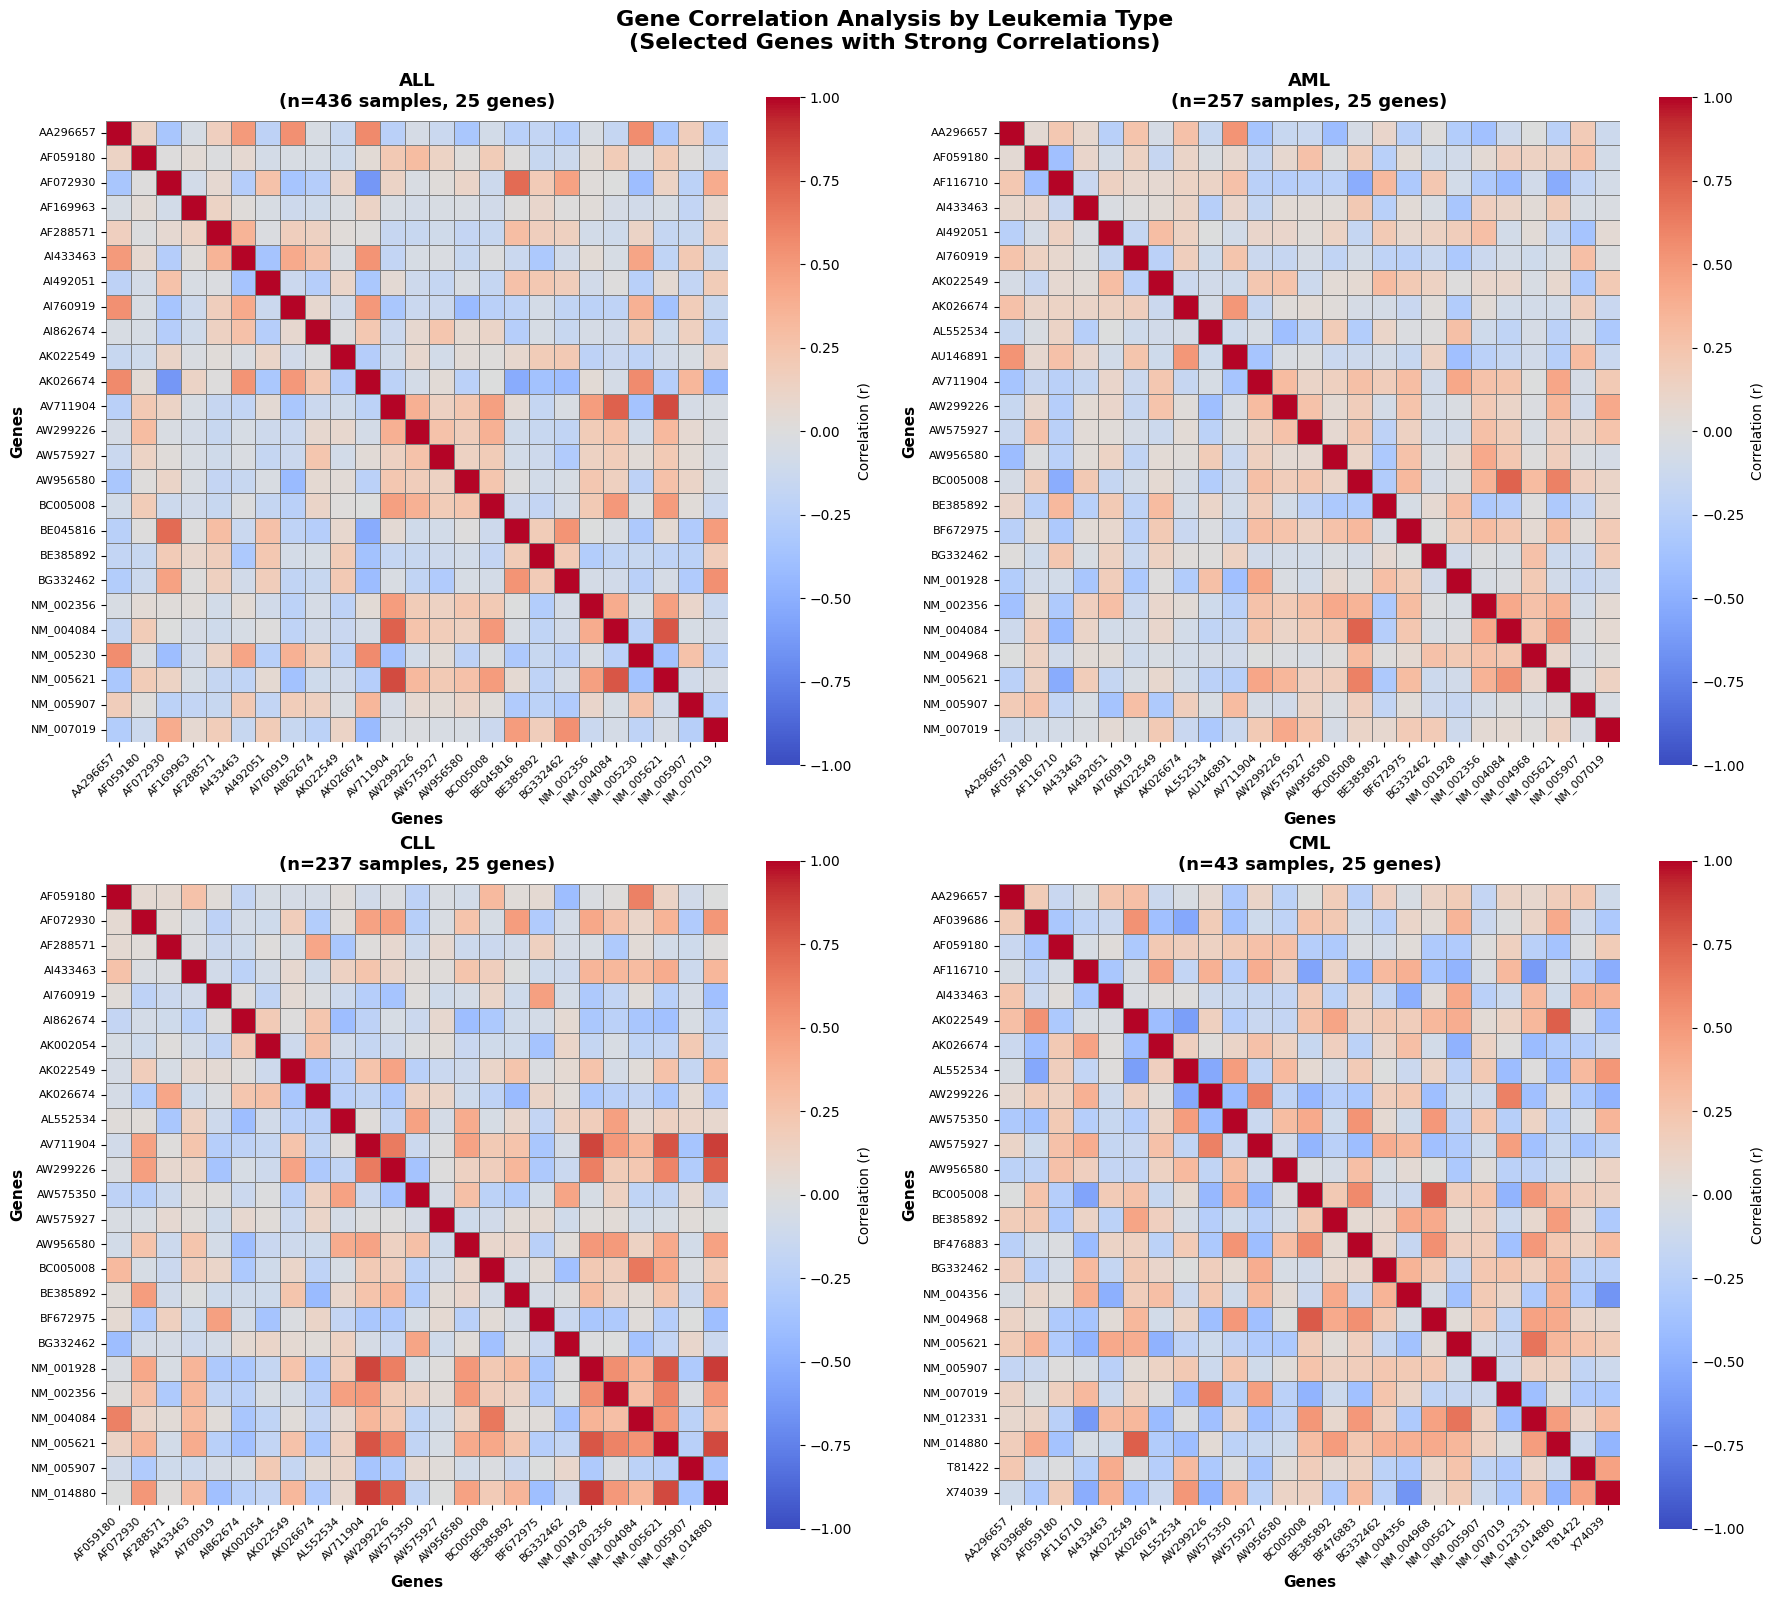

In [21]:
correlation_threshold = 0.7  # Select correlations with |r| >= 0.7
leukemia_types_list = ['ALL', 'AML', 'CLL', 'CML']
correlation_data = {}
selected_genes_by_type = {}

for ltype in leukemia_types_list:
    type_mask = combined_df['Leukemia_Type'] == ltype
    type_data = gene_expression[type_mask]
    
    # calc correlation matrix
    corr_matrix = type_data.corr()
    correlation_data[ltype] = corr_matrix
    
    # find genes with strong correlations (absolute value >= threshold)
    strong_corr_mask = (corr_matrix.abs() >= correlation_threshold) & (corr_matrix != 1.0)
    strong_genes = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if strong_corr_mask.iloc[i, j]:
                strong_genes.add(corr_matrix.columns[i])
                strong_genes.add(corr_matrix.columns[j])
    
    selected_genes_by_type[ltype] = list(strong_genes)[:25]  # limit to 30 genes for clarity

# 2x2 subplot for heatmaps
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Gene Correlation Analysis by Leukemia Type\n(Selected Genes with Strong Correlations)', 
             fontsize=16, fontweight='bold', y=0.995)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
for idx, (ltype, pos) in enumerate(zip(leukemia_types_list, positions)):
    ax = axes[pos]
    selected_genes = sorted(selected_genes_by_type[ltype])
    corr_matrix_subset = correlation_data[ltype].loc[selected_genes, selected_genes]
    sns.heatmap(corr_matrix_subset, 
                ax=ax,
                cmap='coolwarm',
                center=0,
                vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation (r)'},
                square=True,
                linewidths=0.5,
                linecolor='gray',
                xticklabels=True,
                yticklabels=True)
    
    ax.set_title(f'{ltype}\n(n={np.sum(combined_df["Leukemia_Type"] == ltype)} samples, {len(selected_genes)} genes)', 
                fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Genes', fontsize=11, fontweight='bold')
    ax.set_ylabel('Genes', fontsize=11, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

In [22]:
correlation_summary = []
for ltype in leukemia_types_list:
    corr_matrix = correlation_data[ltype]
    # Get upper triangle correlations (exclude diagonal)
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    upper_values = upper_triangle.values[upper_triangle.values != 0]
    
    num_strong_correlations = np.sum(np.abs(upper_values) >= correlation_threshold)
    
    correlation_summary.append({
        'Leukemia_Type': ltype,
        'Mean Correlation Strength (|r|)': np.nanmean(np.abs(upper_values)),
        'Max Positive Correlation (r)': np.nanmax(upper_values),
        'Max Negative Correlation (r)': np.nanmin(upper_values),
        f'Genes with |r| >= {correlation_threshold}': num_strong_correlations
    })

correlation_summary_df = pd.DataFrame(correlation_summary)
print("Correlation Summary Table:")
correlation_summary_df.round(4)

Correlation Summary Table:


,Leukemia_Type,Mean Correlation Strength (|r|),Max Positive Correlation (r),Max Negative Correlation (r),Genes with |r| >= 0.7
0,ALL,0.1284,0.9944,-0.8533,2298
1,AML,0.1111,0.9938,-0.7303,850
2,CLL,0.1245,0.9927,-0.7474,1154
3,CML,0.1691,0.9948,-0.8714,2171


## **P4 - Model Development**

Building and comparing multiple machine learning models for leukemia classification, includes:
- Simple and multiple linear regression models
- Polynomial regression with pipelines
- Ridge and Lasso regularization models
- Neural Network models (using Keras/TensorFlow)
- Model evaluation with R-squared, MSE, and visualizations
- Prediction and decision making
- Model comparison and selection

### **Import Required Libraries**
Load essential libraries for model development, evaluation, and visualization.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### **Load and Prepare Data**

In [24]:
# load cleaned data
features_df = pd.read_csv('GSE13164_cleaned_features.csv', index_col=0)
labels_df = pd.read_csv('GSE13164_cleaned_labels.csv')

# combine features with labels
X = features_df.values
y = labels_df['Target_Code'].values
leukemia_types = labels_df['Leukemia_Type'].values
sample_ids = labels_df['Sample_ID'].values

# split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)

# standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape}")
print(f"Testing set size: {X_test_scaled.shape}")

Training set size: (778, 1420)
Testing set size: (195, 1420)


### **Model 1 - Simple Linear Regression (Baseline)**

In [25]:
model1_simple_lr = LinearRegression()
model1_simple_lr.fit(X_train_scaled[:, :1], y_train)

# predictions
y_train_pred_m1 = model1_simple_lr.predict(X_train_scaled[:, :1])
y_test_pred_m1 = model1_simple_lr.predict(X_test_scaled[:, :1])

# eval metrics
train_mse_m1 = mean_squared_error(y_train, y_train_pred_m1)
test_mse_m1 = mean_squared_error(y_test, y_test_pred_m1)
train_r2_m1 = r2_score(y_train, y_train_pred_m1)
test_r2_m1 = r2_score(y_test, y_test_pred_m1)

print(f"Training MSE: {train_mse_m1:.6f}")
print(f"Testing MSE:  {test_mse_m1:.6f}")
print(f"Training R²:  {train_r2_m1:.6f}")
print(f"Testing R²:   {test_r2_m1:.6f}")
print(f"Model Coefficients: {model1_simple_lr.coef_}")
print(f"Model Intercept: {model1_simple_lr.intercept_:.6f}")

Training MSE: 0.817679
Testing MSE:  0.833054
Training R²:  0.042449
Testing R²:   0.030280
Model Coefficients: [-0.19039117]
Model Intercept: 0.883033


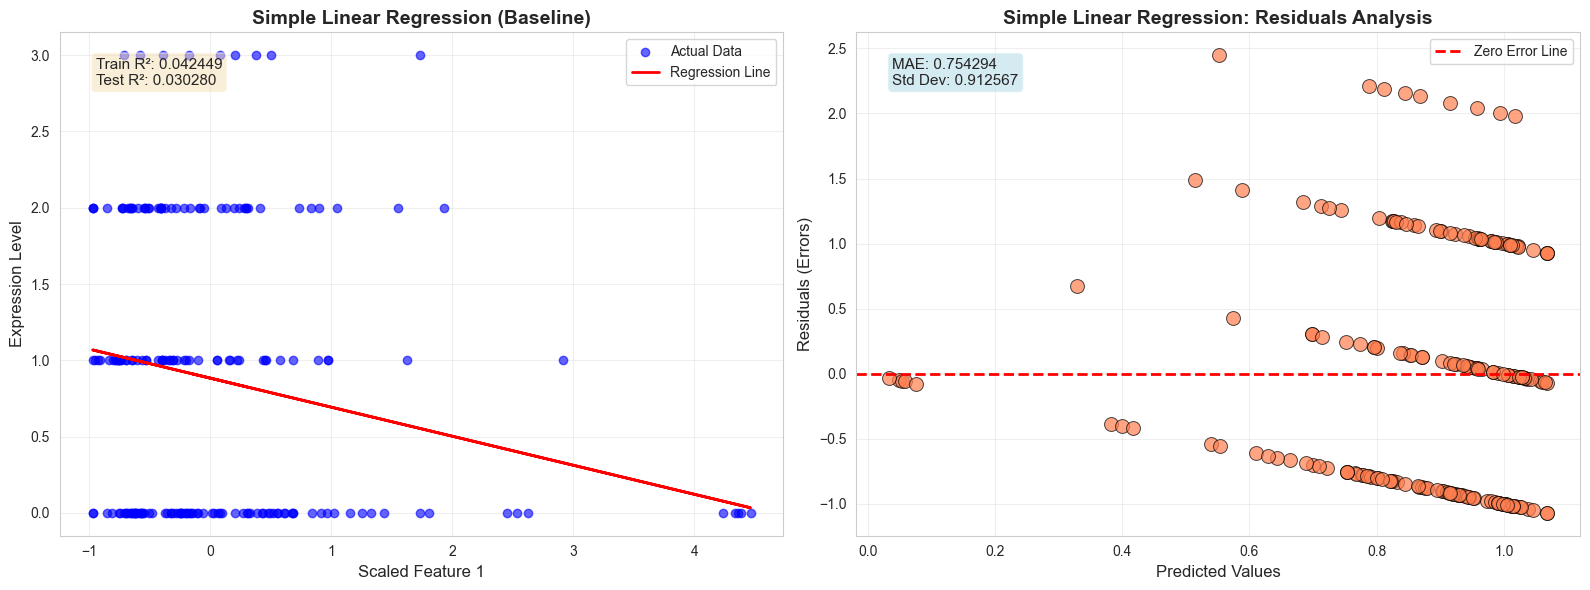

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Regression line with actual data
axes[0].scatter(X_test_scaled[:, :1], y_test, color='blue', label='Actual Data', alpha=0.6)
axes[0].plot(X_test_scaled[:, :1], y_test_pred_m1, color='red', label='Regression Line', linewidth=2)
axes[0].set_xlabel('Scaled Feature 1', fontsize=12)
axes[0].set_ylabel('Expression Level', fontsize=12)
axes[0].set_title('Simple Linear Regression (Baseline)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add metrics text box
metrics_text = f'Train R²: {train_r2_m1:.6f}\nTest R²: {test_r2_m1:.6f}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right plot: Residuals analysis
residuals_m1 = y_test - y_test_pred_m1
axes[1].scatter(y_test_pred_m1, residuals_m1, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Errors)', fontsize=12)
axes[1].set_title('Simple Linear Regression: Residuals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add residuals metrics text box
mae_m1 = np.mean(np.abs(residuals_m1))
residuals_text = f'MAE: {mae_m1:.6f}\nStd Dev: {np.std(residuals_m1):.6f}'
axes[1].text(0.05, 0.95, residuals_text, transform=axes[1].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

### **Model 2 - Multiple Linear Regression**

Build a linear regression model using all available gene expression features. This captures relationships across the entire feature space.

In [27]:
model2_multiple_lr = LinearRegression()
model2_multiple_lr.fit(X_train_scaled, y_train)

# predictions
y_train_pred_m2 = model2_multiple_lr.predict(X_train_scaled)
y_test_pred_m2 = model2_multiple_lr.predict(X_test_scaled)

train_mse_m2 = mean_squared_error(y_train, y_train_pred_m2)
test_mse_m2 = mean_squared_error(y_test, y_test_pred_m2)
train_r2_m2 = r2_score(y_train, y_train_pred_m2)
test_r2_m2 = r2_score(y_test, y_test_pred_m2)

print(f"Training MSE: {train_mse_m2:.6f}")
print(f"Testing MSE:  {test_mse_m2:.6f}")
print(f"Training R²:  {train_r2_m2:.6f}")
print(f"Testing R²:   {test_r2_m2:.6f}")
print(f"Model Intercept: {model2_multiple_lr.intercept_:.6f}")
print(f"Number of coefficients: {len(model2_multiple_lr.coef_)}")

Training MSE: 0.000000
Testing MSE:  0.153705
Training R²:  1.000000
Testing R²:   0.821079
Model Intercept: 0.883033
Number of coefficients: 1420


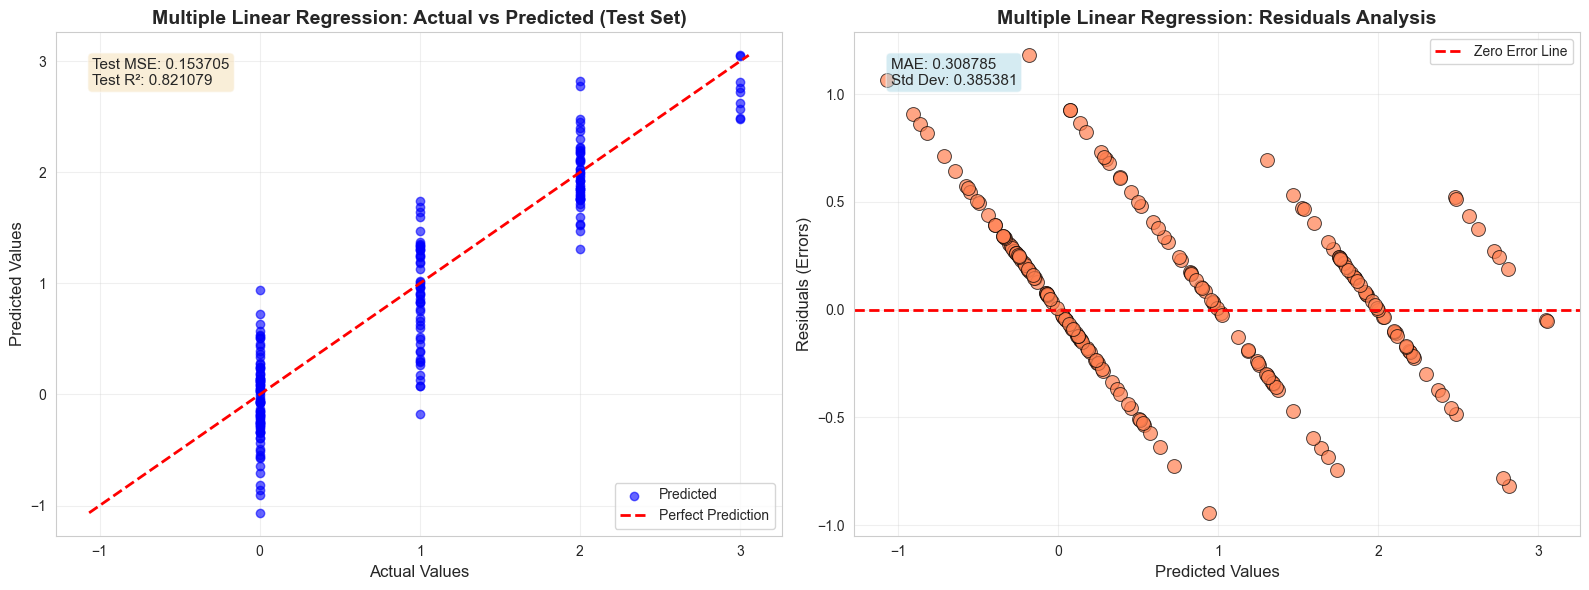

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# multiple lr
axes[0].scatter(y_test, y_test_pred_m2, alpha=0.6, color='blue', label='Predicted')
min_val = min(y_test.min(), y_test_pred_m2.min())
max_val = max(y_test.max(), y_test_pred_m2.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title('Multiple Linear Regression: Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
metrics_text = f'Test MSE: {test_mse_m2:.6f}\nTest R²: {test_r2_m2:.6f}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# residual analysis
residuals_m2 = y_test - y_test_pred_m2
axes[1].scatter(y_test_pred_m2, residuals_m2, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Errors)', fontsize=12)
axes[1].set_title('Multiple Linear Regression: Residuals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
mae_m2 = np.mean(np.abs(residuals_m2))
residuals_text = f'MAE: {mae_m2:.6f}\nStd Dev: {np.std(residuals_m2):.6f}'
axes[1].text(0.05, 0.95, residuals_text, transform=axes[1].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

### **Model 3 - Polynomial Regression with Pipeline**
Used scikit-learn pipelines to capture non-linear relationships between genes and leukemia types.

In [29]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
])

model3_poly = poly_pipeline.fit(X_train_scaled, y_train)

# predictions
y_train_pred_m3 = model3_poly.predict(X_train_scaled)
y_test_pred_m3 = model3_poly.predict(X_test_scaled)

# eval metrics
train_mse_m3 = mean_squared_error(y_train, y_train_pred_m3)
test_mse_m3 = mean_squared_error(y_test, y_test_pred_m3)
train_r2_m3 = r2_score(y_train, y_train_pred_m3)
test_r2_m3 = r2_score(y_test, y_test_pred_m3)

print(f"Training MSE: {train_mse_m3:.6f}")
print(f"Testing MSE:  {test_mse_m3:.6f}")
print(f"Training R²:  {train_r2_m3:.6f}")
print(f"Testing R²:   {test_r2_m3:.6f}")
print(f"Polynomial features shape: {model3_poly.named_steps['poly_features'].n_output_features_}")

Training MSE: 0.000000
Testing MSE:  0.032354
Training R²:  1.000000
Testing R²:   0.962338
Polynomial features shape: 1010330


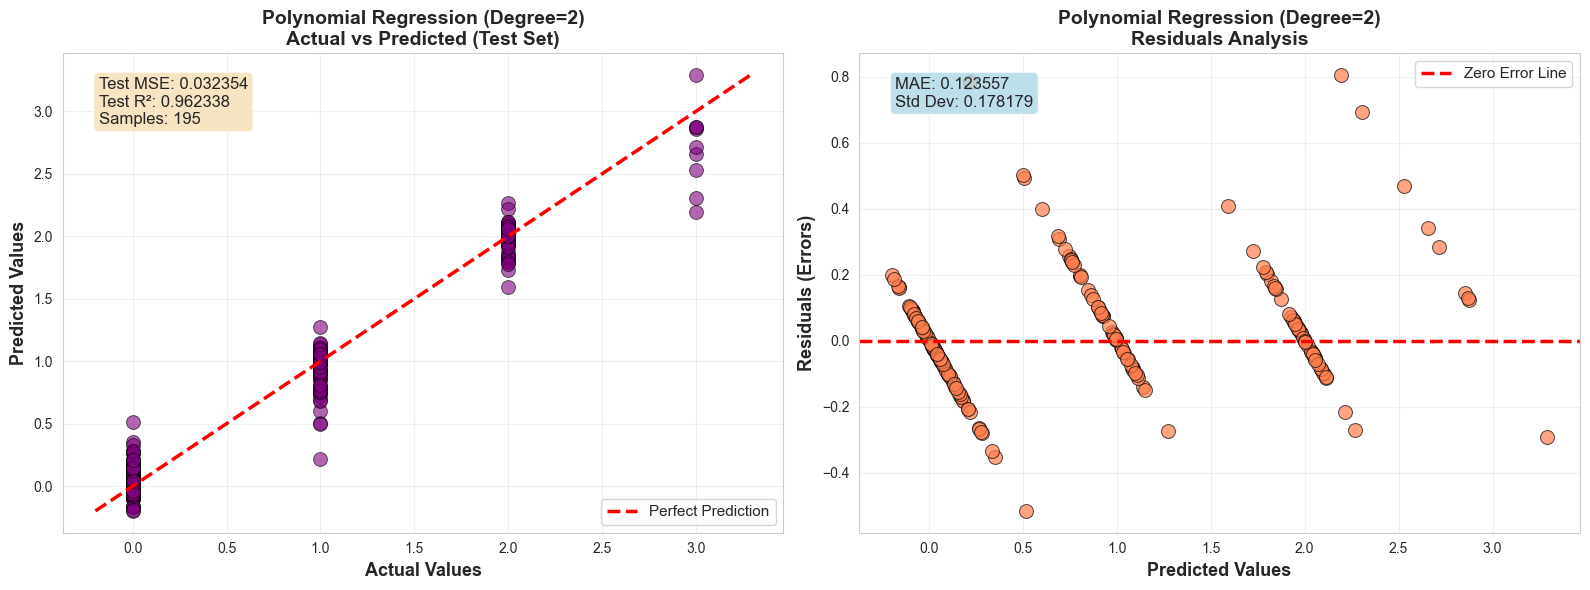

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# polynomial lr
axes[0].scatter(y_test, y_test_pred_m3, alpha=0.6, s=100, color='purple', edgecolors='k', linewidth=0.7)
min_val = min(y_test.min(), y_test_pred_m3.min())
max_val = max(y_test.max(), y_test_pred_m3.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2.5, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Predicted Values', fontsize=13, fontweight='bold')
axes[0].set_title('Polynomial Regression (Degree=2)\nActual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
metrics_text = f'Test MSE: {test_mse_m3:.6f}\nTest R²: {test_r2_m3:.6f}\nSamples: {len(y_test)}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# residuals analysis
residuals_m3 = y_test - y_test_pred_m3
axes[1].scatter(y_test_pred_m3, residuals_m3, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2.5, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Residuals (Errors)', fontsize=13, fontweight='bold')
axes[1].set_title('Polynomial Regression (Degree=2)\nResiduals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
mae_m3 = np.mean(np.abs(residuals_m3))
axes[1].text(0.05, 0.95, f'MAE: {mae_m3:.6f}\nStd Dev: {np.std(residuals_m3):.6f}', 
            transform=axes[1].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

### **Model 4 - Ridge Regression (L2 Regularization)**
To reduce overfitting and improve generalization on test data.

In [31]:
# ridge regression with hyperparameter tuning
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)

model4_ridge = ridge_grid.best_estimator_

# predictions
y_train_pred_m4 = model4_ridge.predict(X_train_scaled)
y_test_pred_m4 = model4_ridge.predict(X_test_scaled)

# eval metrics
train_mse_m4 = mean_squared_error(y_train, y_train_pred_m4)
test_mse_m4 = mean_squared_error(y_test, y_test_pred_m4)
train_r2_m4 = r2_score(y_train, y_train_pred_m4)
test_r2_m4 = r2_score(y_test, y_test_pred_m4)

print(f"Best alpha (regularization): {ridge_grid.best_params_['alpha']}")
print(f"Training MSE: {train_mse_m4:.6f}")
print(f"Testing MSE:  {test_mse_m4:.6f}")
print(f"Training R²:  {train_r2_m4:.6f}")
print(f"Testing R²:   {test_r2_m4:.6f}")

Best alpha (regularization): 100
Training MSE: 0.008942
Testing MSE:  0.067925
Training R²:  0.989528
Testing R²:   0.920932


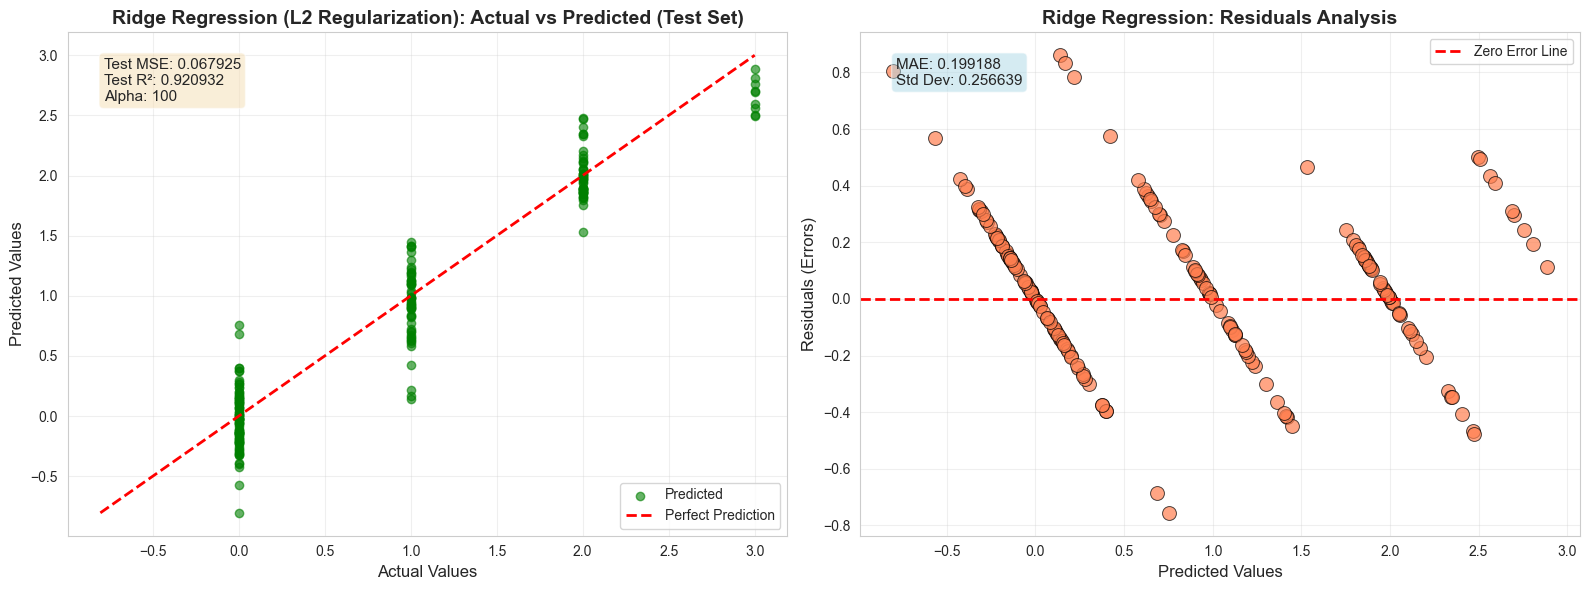

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Actual vs Predicted
axes[0].scatter(y_test, y_test_pred_m4, alpha=0.6, color='green', label='Predicted')

# Add diagonal reference line (perfect prediction)
min_val = min(y_test.min(), y_test_pred_m4.min())
max_val = max(y_test.max(), y_test_pred_m4.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Labels and title for left plot
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title('Ridge Regression (L2 Regularization): Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add metrics text box
metrics_text = f'Test MSE: {test_mse_m4:.6f}\nTest R²: {test_r2_m4:.6f}\nAlpha: {ridge_grid.best_params_["alpha"]}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right plot: Residuals Analysis
residuals_m4 = y_test - y_test_pred_m4
axes[1].scatter(y_test_pred_m4, residuals_m4, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Errors)', fontsize=12)
axes[1].set_title('Ridge Regression: Residuals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add residuals metrics text box
mae_m4 = np.mean(np.abs(residuals_m4))
residuals_text = f'MAE: {mae_m4:.6f}\nStd Dev: {np.std(residuals_m4):.6f}'
axes[1].text(0.05, 0.95, residuals_text, transform=axes[1].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

### **Model 5 - Lasso Regression (L1 Regularization)**
To feature selection and improved interpretability.

In [33]:
# lasso reg with hyperparameter tuning
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)

model5_lasso = lasso_grid.best_estimator_

# predictions
y_train_pred_m5 = model5_lasso.predict(X_train_scaled)
y_test_pred_m5 = model5_lasso.predict(X_test_scaled)

# eval metrics
train_mse_m5 = mean_squared_error(y_train, y_train_pred_m5)
test_mse_m5 = mean_squared_error(y_test, y_test_pred_m5)
train_r2_m5 = r2_score(y_train, y_train_pred_m5)
test_r2_m5 = r2_score(y_test, y_test_pred_m5)

# count non-zero coefficients (selected features)
non_zero_coefs = np.sum(model5_lasso.coef_ != 0)

print(f"Best alpha (regularization): {lasso_grid.best_params_['alpha']}")
print(f"Training MSE: {train_mse_m5:.6f}")
print(f"Testing MSE:  {test_mse_m5:.6f}")
print(f"Training R²:  {train_r2_m5:.6f}")
print(f"Testing R²:   {test_r2_m5:.6f}")
print(f"Selected features: {non_zero_coefs} out of {len(model5_lasso.coef_)}")

Best alpha (regularization): 0.01
Training MSE: 0.044228
Testing MSE:  0.059842
Training R²:  0.948206
Testing R²:   0.930341
Selected features: 203 out of 1420


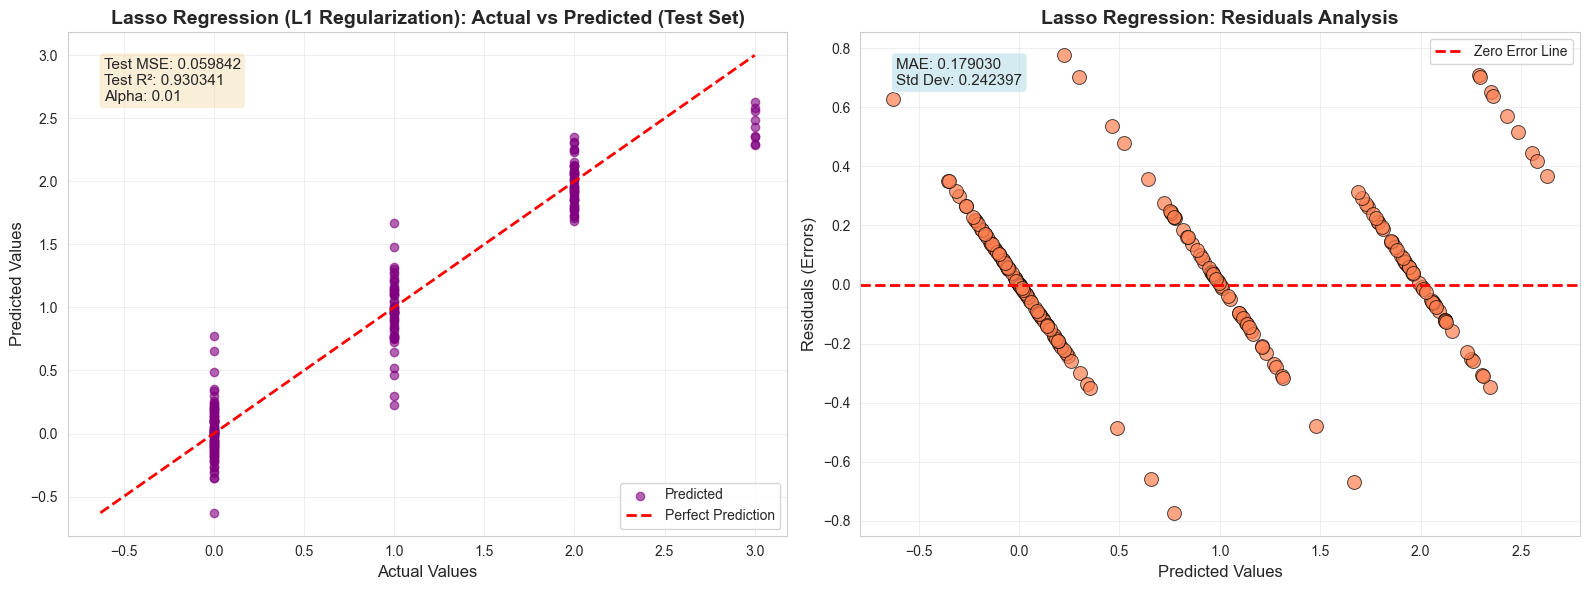

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# lasso reg
axes[0].scatter(y_test, y_test_pred_m5, alpha=0.6, color='purple', label='Predicted')
min_val = min(y_test.min(), y_test_pred_m5.min())
max_val = max(y_test.max(), y_test_pred_m5.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title('Lasso Regression (L1 Regularization): Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
metrics_text = f'Test MSE: {test_mse_m5:.6f}\nTest R²: {test_r2_m5:.6f}\nAlpha: {lasso_grid.best_params_["alpha"]}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# residual analysis
residuals_m5 = y_test - y_test_pred_m5
axes[1].scatter(y_test_pred_m5, residuals_m5, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Errors)', fontsize=12)
axes[1].set_title('Lasso Regression: Residuals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
mae_m5 = np.mean(np.abs(residuals_m5))
residuals_text = f'MAE: {mae_m5:.6f}\nStd Dev: {np.std(residuals_m5):.6f}'
axes[1].text(0.05, 0.95, residuals_text, transform=axes[1].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

### **Model 6 - Neural Network**
Build a deep neural network model using Keras/TensorFlow with multiple layers, batch normalization, and dropout for improved performance and generalization.

In [35]:
model6_nn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='linear')  # Linear activation for regression
])

# compile the model
model6_nn.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='mse', 
                   metrics=['mae'])

# train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model6_nn.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# predictions
y_train_pred_m6 = model6_nn.predict(X_train_scaled, verbose=0).flatten()
y_test_pred_m6 = model6_nn.predict(X_test_scaled, verbose=0).flatten()

# eval metrics
train_mse_m6 = mean_squared_error(y_train, y_train_pred_m6)
test_mse_m6 = mean_squared_error(y_test, y_test_pred_m6)
train_r2_m6 = r2_score(y_train, y_train_pred_m6)
test_r2_m6 = r2_score(y_test, y_test_pred_m6)

print(f"Training MSE: {train_mse_m6:.6f}")
print(f"Testing MSE:  {test_mse_m6:.6f}")
print(f"Training R²:  {train_r2_m6:.6f}")
print(f"Testing R²:   {test_r2_m6:.6f}")
print(f"Training epochs: {len(history.history['loss'])}")
print("Model Summary:")
print(model6_nn.summary())

Training MSE: 0.012506
Testing MSE:  0.017728
Training R²:  0.985355
Testing R²:   0.979364
Training epochs: 94
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       363,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224,709 (4.67 MB)

 Trainable params: 407,937 (1.56 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 815,876 (3.11 MB)

None


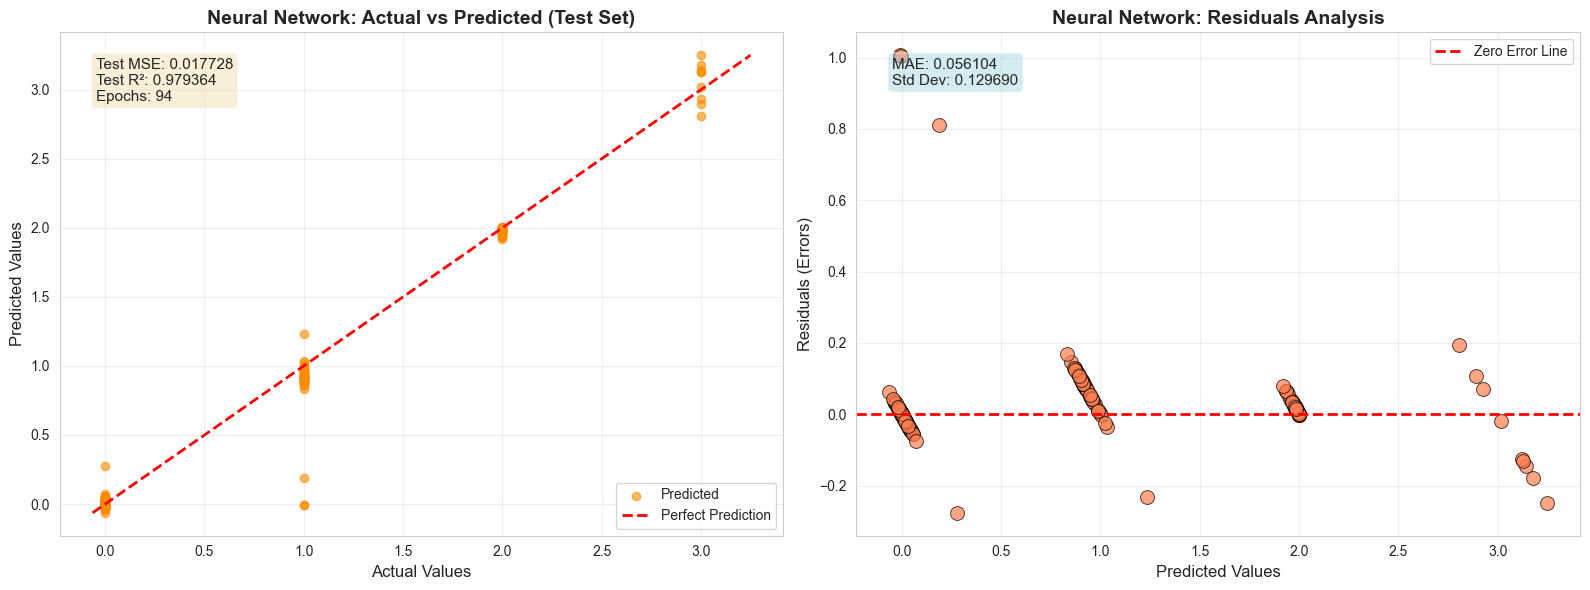

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# neural network
axes[0].scatter(y_test, y_test_pred_m6, alpha=0.6, color='darkorange', label='Predicted')
min_val = min(y_test.min(), y_test_pred_m6.min())
max_val = max(y_test.max(), y_test_pred_m6.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title('Neural Network: Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
metrics_text = f'Test MSE: {test_mse_m6:.6f}\nTest R²: {test_r2_m6:.6f}\nEpochs: {len(history.history["loss"])}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# residuals analysis
residuals_m6 = y_test - y_test_pred_m6
axes[1].scatter(y_test_pred_m6, residuals_m6, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Errors)', fontsize=12)
axes[1].set_title('Neural Network: Residuals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
mae_m6 = np.mean(np.abs(residuals_m6))
residuals_text = f'MAE: {mae_m6:.6f}\nStd Dev: {np.std(residuals_m6):.6f}'
axes[1].text(0.05, 0.95, residuals_text, transform=axes[1].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

### **Model 7 - Random Forest Regressor**

In [37]:
from sklearn.ensemble import RandomForestRegressor

# random forest reg with hyperparameter tuning
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

model7_rf = rf_grid.best_estimator_

# predictions
y_train_pred_m7 = model7_rf.predict(X_train_scaled)
y_test_pred_m7 = model7_rf.predict(X_test_scaled)

# eval metrics
train_mse_m7 = mean_squared_error(y_train, y_train_pred_m7)
test_mse_m7 = mean_squared_error(y_test, y_test_pred_m7)
train_r2_m7 = r2_score(y_train, y_train_pred_m7)
test_r2_m7 = r2_score(y_test, y_test_pred_m7)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Training MSE: {train_mse_m7:.6f}")
print(f"Testing MSE:  {test_mse_m7:.6f}")
print(f"Training R²:  {train_r2_m7:.6f}")
print(f"Testing R²:   {test_r2_m7:.6f}")
print(f"Feature importance (top 10):")
feature_importance = sorted(enumerate(model7_rf.feature_importances_), key=lambda x: x[1], reverse=True)
for idx, importance in feature_importance[:10]:
    print(f"  Feature {idx}: {importance:.6f}")

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Training MSE: 0.009576
Testing MSE:  0.061498
Training R²:  0.988786
Testing R²:   0.928413
Feature importance (top 10):
  Feature 803: 0.594421
  Feature 281: 0.081622
  Feature 338: 0.060883
  Feature 212: 0.032133
  Feature 601: 0.029718
  Feature 760: 0.014735
  Feature 416: 0.014681
  Feature 69: 0.011723
  Feature 1135: 0.010500
  Feature 39: 0.006736


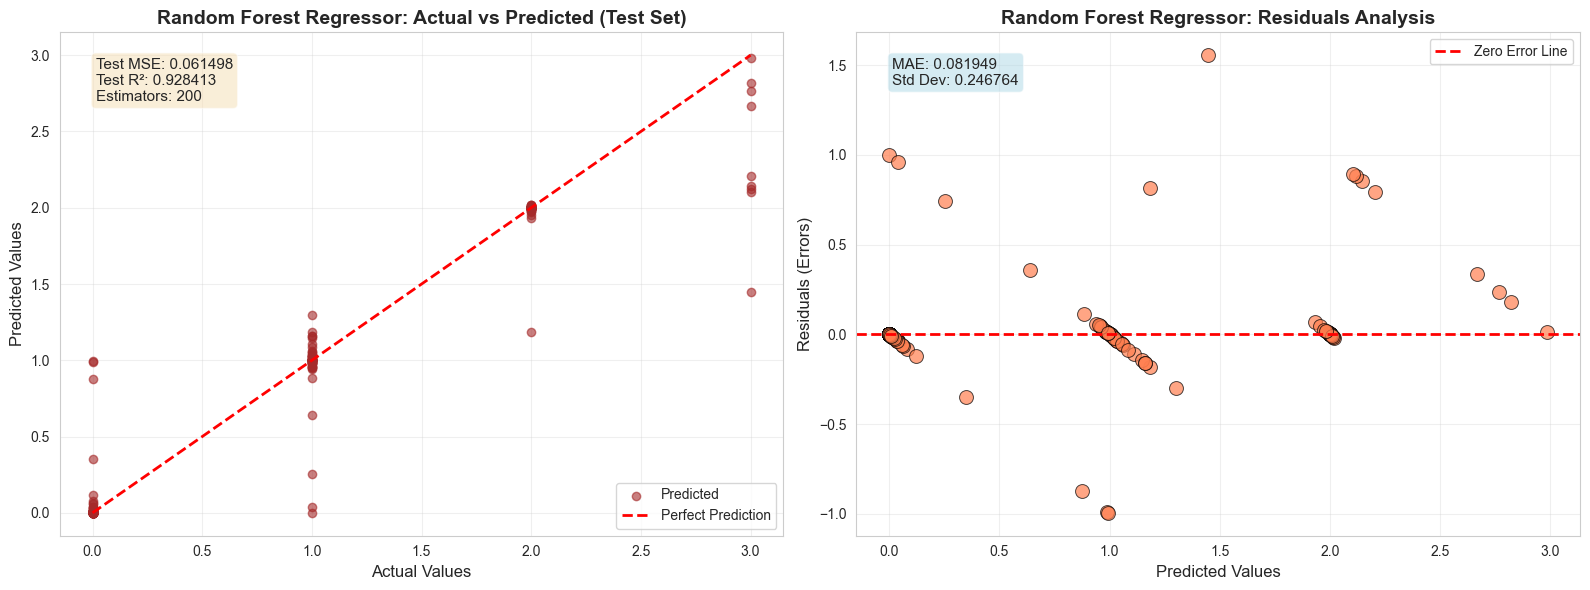

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# random forest
axes[0].scatter(y_test, y_test_pred_m7, alpha=0.6, color='brown', label='Predicted')

# Add diagonal reference line (perfect prediction)
min_val = min(y_test.min(), y_test_pred_m7.min())
max_val = max(y_test.max(), y_test_pred_m7.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title('Random Forest Regressor: Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
metrics_text = f'Test MSE: {test_mse_m7:.6f}\nTest R²: {test_r2_m7:.6f}\nEstimators: {rf_grid.best_params_["n_estimators"]}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# residuals analysis
residuals_m7 = y_test - y_test_pred_m7
axes[1].scatter(y_test_pred_m7, residuals_m7, alpha=0.7, s=100, color='coral', edgecolors='k', linewidth=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error Line')
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals (Errors)', fontsize=12)
axes[1].set_title('Random Forest Regressor: Residuals Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
mae_m7 = np.mean(np.abs(residuals_m7))
residuals_text = f'MAE: {mae_m7:.6f}\nStd Dev: {np.std(residuals_m7):.6f}'
axes[1].text(0.05, 0.95, residuals_text, transform=axes[1].transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

### **R-squared and MSE Comparison Among Models**

In [58]:
# comparison df
comparison_df = pd.DataFrame({
    'Model': [
        'Simple LR',
        'Multiple LR',
        'Polynomial (deg=2)',
        'Ridge',
        'Lasso',
        'Neural Network',
        'Random Forest'
    ],
    'Train MSE': [train_mse_m1, train_mse_m2, train_mse_m3, train_mse_m4, train_mse_m5, train_mse_m6, train_mse_m7],
    'Test MSE': [test_mse_m1, test_mse_m2, test_mse_m3, test_mse_m4, test_mse_m5, test_mse_m6, test_mse_m7],
    'Train R²': [train_r2_m1, train_r2_m2, train_r2_m3, train_r2_m4, train_r2_m5, train_r2_m6, train_r2_m7],
    'Test R²': [test_r2_m1, test_r2_m2, test_r2_m3, test_r2_m4, test_r2_m5, test_r2_m6, test_r2_m7]
})

test_preds = [y_test_pred_m1, y_test_pred_m2, y_test_pred_m3, y_test_pred_m4, y_test_pred_m5, y_test_pred_m6, y_test_pred_m7]
accuracies = []
for pred in test_preds:
    class_pred = np.clip(np.round(pred), 0, 3).astype(int)
    accuracies.append(accuracy_score(y_test, class_pred))
comparison_df['Test Accuracy'] = accuracies
comparison_df['Test Accuracy'] = comparison_df['Test Accuracy'].map('{:.2%}'.format)

comparison_df

,Model,Train MSE,Test MSE,Train R²,Test R²,Test Accuracy
0,Simple LR,8.176793e-01,0.833054,0.042449,0.030280,30.26%
1,Multiple LR,1.730419e-29,0.153705,1.000000,0.821079,84.62%
2,Polynomial (deg=2),4.880883e-28,0.032354,1.000000,0.962338,97.44%
3,Ridge,8.942474e-03,0.067925,0.989528,0.920932,96.41%
4,Lasso,4.422814e-02,0.059842,0.948206,0.930341,93.85%
5,Neural Network,1.250577e-02,0.017728,0.985355,0.979364,98.46%
6,Random Forest,9.576060e-03,0.061498,0.988786,0.928413,93.85%


In [40]:
# best model (lowest mse & highest r2)
best_test_r2_idx = comparison_df['Test R²'].idxmax()
best_test_mse_idx = comparison_df['Test MSE'].idxmin()
print(f"\nBest Test R²: {comparison_df.loc[best_test_r2_idx, 'Model']} ({comparison_df.loc[best_test_r2_idx, 'Test R²']:.6f})")
print(f"Best Test MSE: {comparison_df.loc[best_test_mse_idx, 'Model']} ({comparison_df.loc[best_test_mse_idx, 'Test MSE']:.6f})")


Best Test R²: Neural Network (0.979364)
Best Test MSE: Neural Network (0.017728)


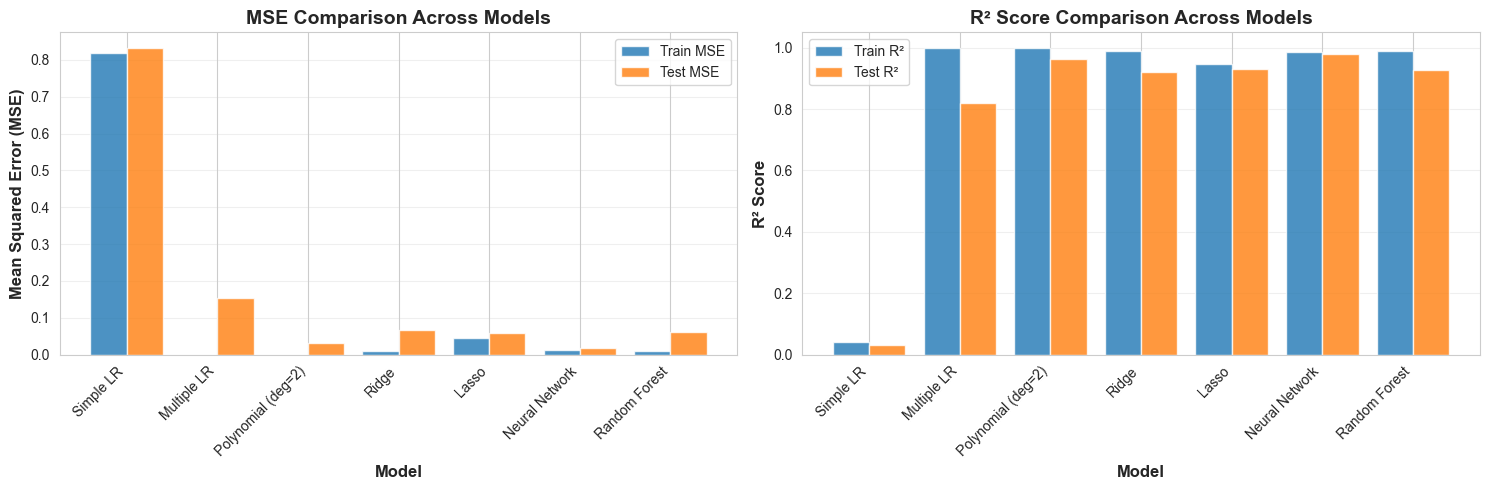

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# mse comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos - 0.2, comparison_df['Train MSE'], 0.4, label='Train MSE', alpha=0.8)
axes[0].bar(x_pos + 0.2, comparison_df['Test MSE'], 0.4, label='Test MSE', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('MSE Comparison Across Models', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# r2 comparison
axes[1].bar(x_pos - 0.2, comparison_df['Train R²'], 0.4, label='Train R²', alpha=0.8)
axes[1].bar(x_pos + 0.2, comparison_df['Test R²'], 0.4, label='Test R²', alpha=0.8)
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('R² Score Comparison Across Models', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### **Prediction and Decision Making**

Make predictions on test data using the best model and demonstrate classification of samples by leukemia type based on continuous predictions.


In [42]:
# neural network for predictions
best_model = model6_nn
y_test_pred_best = y_test_pred_m6
y_test_pred_class = np.round(y_test_pred_best).astype(int)
y_test_pred_class = np.clip(y_test_pred_class, 0, 3)  # Ensure within valid range
class_to_type = {0: 'ALL', 1: 'AML', 2: 'CLL', 3: 'CML'}
y_test_true_types = [class_to_type[y] for y in y_test]
y_test_pred_types = [class_to_type[y] for y in y_test_pred_class]

# predictions df
predictions_df = pd.DataFrame({
    'Sample_ID': sample_ids[idx_test],
    'Actual_Class': y_test,
    'Predicted_Class': y_test_pred_class,
    'Continuous_Prediction': y_test_pred_best,
    'Actual_Type': y_test_true_types,
    'Predicted_Type': y_test_pred_types,
    'Prediction_Error': y_test - y_test_pred_best,
    'Correct': y_test == y_test_pred_class
})

print("Predictions & Decision Making (Test Set - First 15 samples):")
print(predictions_df.head(15).to_string(index=False))

# classification accuracy
accuracy = np.sum(predictions_df['Correct']) / len(predictions_df)
print(f"\nOverall Classification Accuracy: {accuracy:.4f} ({np.sum(predictions_df['Correct'])}/{len(predictions_df)})")

# accuracy by leukemia type
print("\nAccuracy by Leukemia Type:")
for ltype in ['ALL', 'AML', 'CLL', 'CML']:
    mask = predictions_df['Actual_Type'] == ltype
    type_acc = np.sum(predictions_df.loc[mask, 'Correct']) / np.sum(mask) if np.sum(mask) > 0 else 0
    print(f"  {ltype}: {type_acc:.4f} ({np.sum(predictions_df.loc[mask, 'Correct'])}/{np.sum(mask)})")

# misclassified samples
print("\nMisclasified Samples:")
misclassified = predictions_df[~predictions_df['Correct']]
print(misclassified[['Sample_ID', 'Actual_Type', 'Predicted_Type', 'Continuous_Prediction', 'Prediction_Error']].to_string(index=False))

Predictions & Decision Making (Test Set - First 15 samples):
Sample_ID  Actual_Class  Predicted_Class  Continuous_Prediction Actual_Type Predicted_Type  Prediction_Error  Correct
GSM332231             0                0              -0.005883         ALL            ALL          0.005883     True
GSM332565             1                1               0.880859         AML            AML          0.119141     True
GSM332829             0                0              -0.033024         ALL            ALL          0.033024     True
GSM332555             0                0              -0.022648         ALL            ALL          0.022648     True
GSM331842             0                0              -0.063428         ALL            ALL          0.063428     True
GSM332163             1                1               0.995930         AML            AML          0.004070     True
GSM332650             1                1               0.929664         AML            AML          0.070336     

## **P5 - Model Evaluation**

### **Neural Network: Training History**

Plot the training history showing loss curves to analyze model convergence during training.


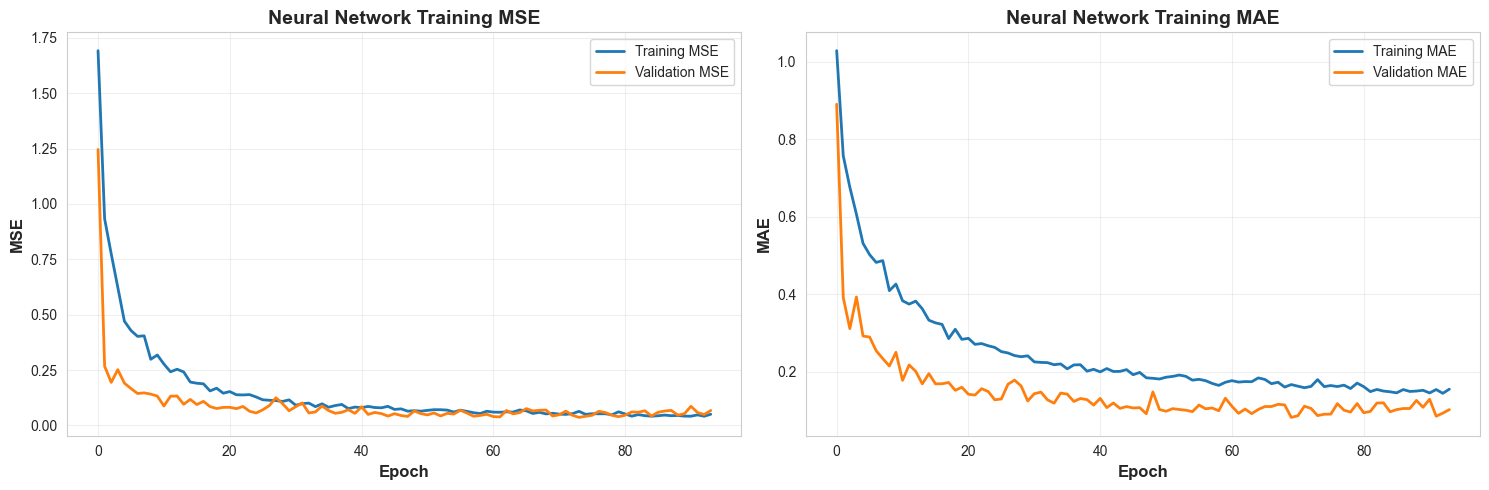

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# loss curves
axes[0].plot(history.history['loss'], label='Training MSE', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation MSE', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MSE', fontsize=12, fontweight='bold')
axes[0].set_title('Neural Network Training MSE', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE curves
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Neural Network Training MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### **Confusion Matrix and Classification Report**
Display confusion matrix and detailed classification metrics for the best model.

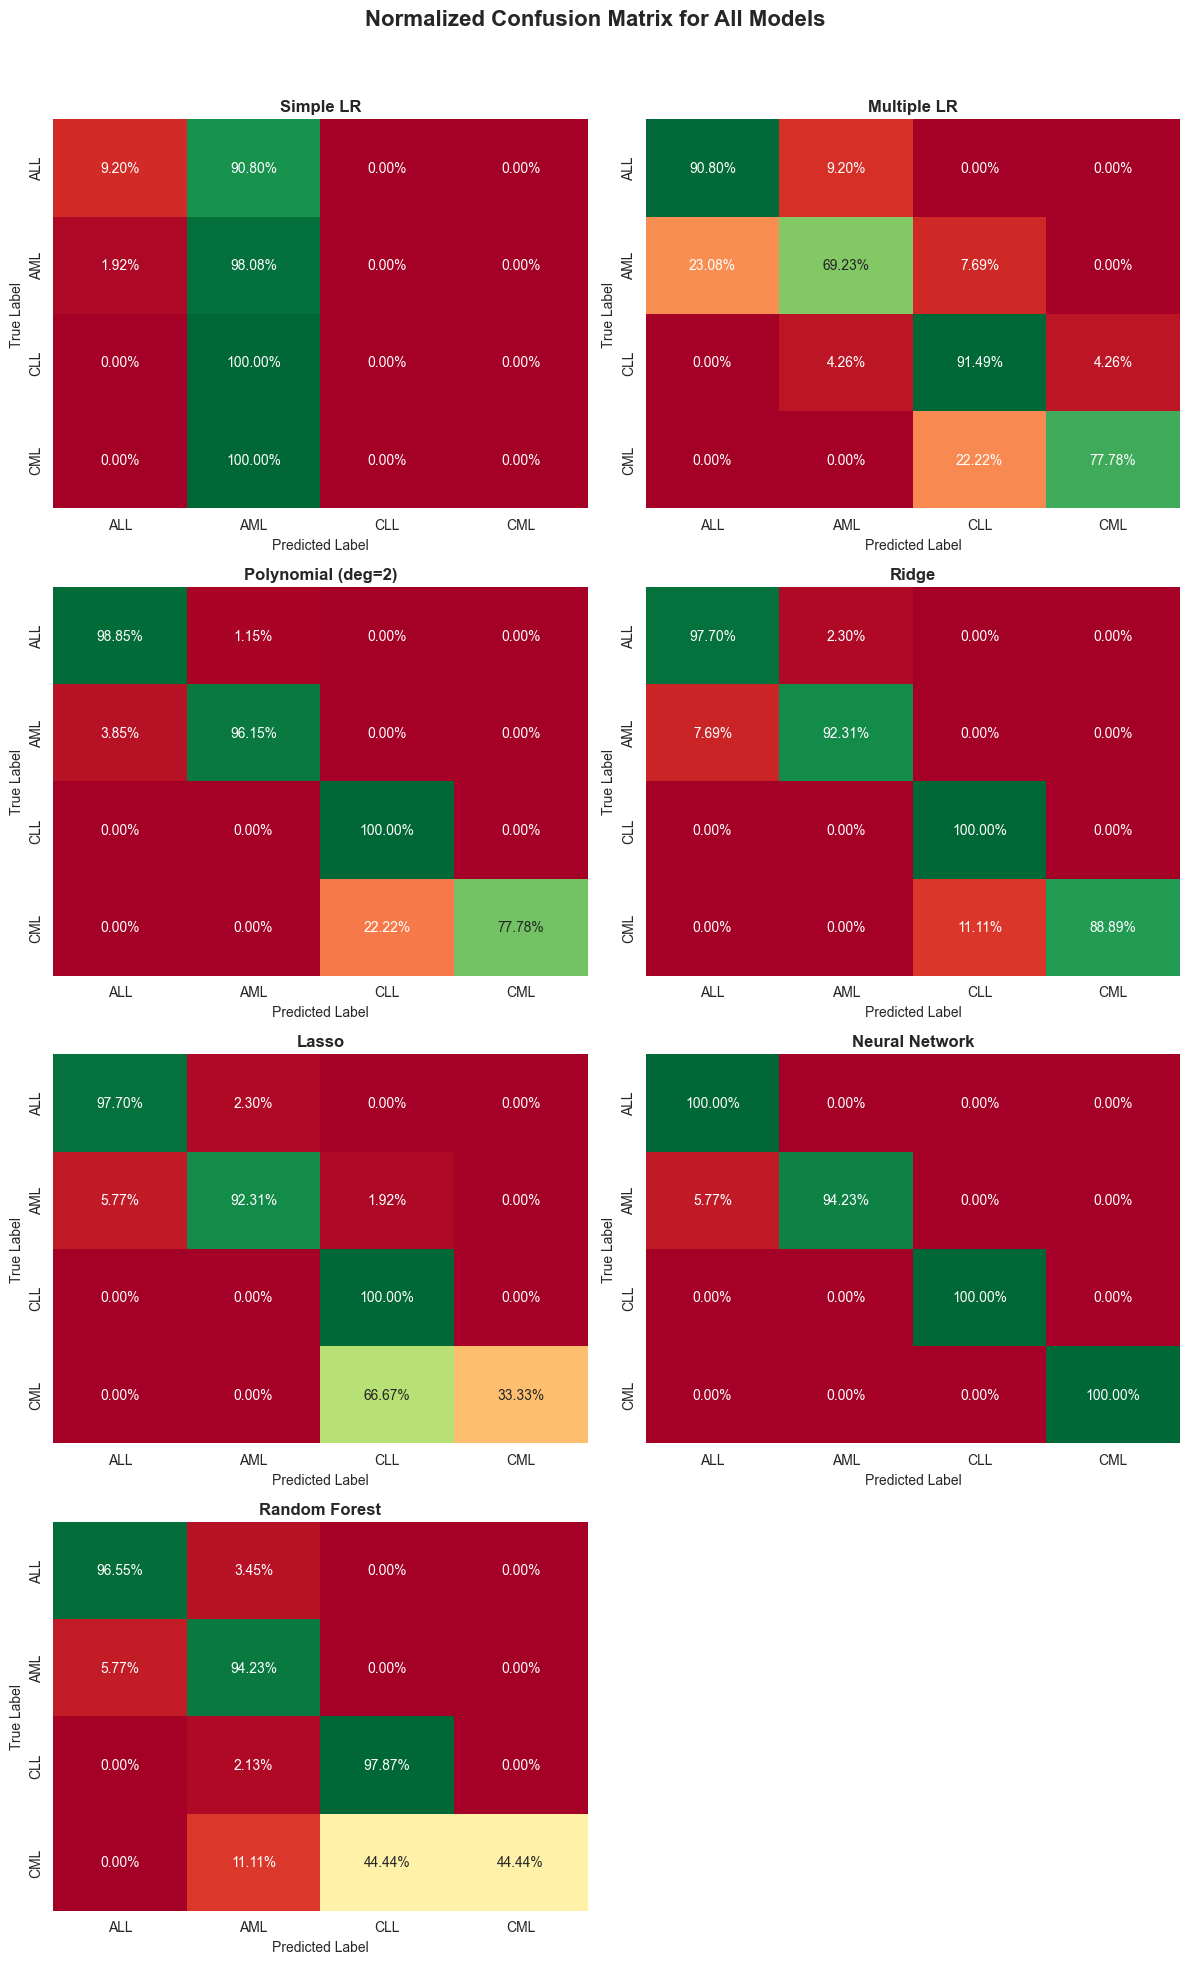

In [65]:
cm = confusion_matrix(y_test, y_test_pred_class)

# --- Create predictions for all models ---
all_preds = {
    'Simple LR': y_test_pred_m1,
    'Multiple LR': y_test_pred_m2,
    'Polynomial (deg=2)': y_test_pred_m3,
    'Ridge': y_test_pred_m4,
    'Lasso': y_test_pred_m5,
    'Neural Network': y_test_pred_m6,
    'Random Forest': y_test_pred_m7
}

all_class_preds = {name: np.clip(np.round(pred), 0, 3).astype(int) for name, pred in all_preds.items()}
class_names = ['ALL', 'AML', 'CLL', 'CML']

# --- Plot all confusion matrices ---
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
fig.suptitle('Normalized Confusion Matrix for All Models', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, (model_name, y_pred) in enumerate(all_class_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', cbar=False, ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    
    axes[i].set_title(model_name, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted Label', fontsize=10)
    axes[i].set_ylabel('True Label', fontsize=10)

# Hide the last unused subplot
if len(all_class_preds) < len(axes):
    for j in range(len(all_class_preds), len(axes)):
        axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [45]:
# Classification report
print("Detailed Classification Report:")
class_names = ['ALL', 'AML', 'CLL', 'CML']
print(classification_report(y_test, y_test_pred_class, target_names=class_names, digits=4))

Detailed Classification Report:
              precision    recall  f1-score   support

         ALL     0.9667    1.0000    0.9831        87
         AML     1.0000    0.9423    0.9703        52
         CLL     1.0000    1.0000    1.0000        47
         CML     1.0000    1.0000    1.0000         9

    accuracy                         0.9846       195
   macro avg     0.9917    0.9856    0.9883       195
weighted avg     0.9851    0.9846    0.9845       195



### **Over-fiting, Under-fitting & Model Selection**

In [67]:
# differences between train and test metrics
comparison_df['R2_Diff (Train - Test)'] = comparison_df['Train R²'] - comparison_df['Test R²']
comparison_df['MSE_Diff (Test - Train)'] = comparison_df['Test MSE'] - comparison_df['Train MSE']

print("Performance Differences (Train vs. Test):")
comparison_df[['Model', 'R2_Diff (Train - Test)', 'MSE_Diff (Test - Train)']]

Performance Differences (Train vs. Test):


,Model,R2_Diff (Train - Test),MSE_Diff (Test - Train)
0,Simple LR,0.012170,0.015375
1,Multiple LR,0.178921,0.153705
2,Polynomial (deg=2),0.037662,0.032354
3,Ridge,0.068596,0.058982
4,Lasso,0.017865,0.015613
5,Neural Network,0.005991,0.005222
6,Random Forest,0.060373,0.051922


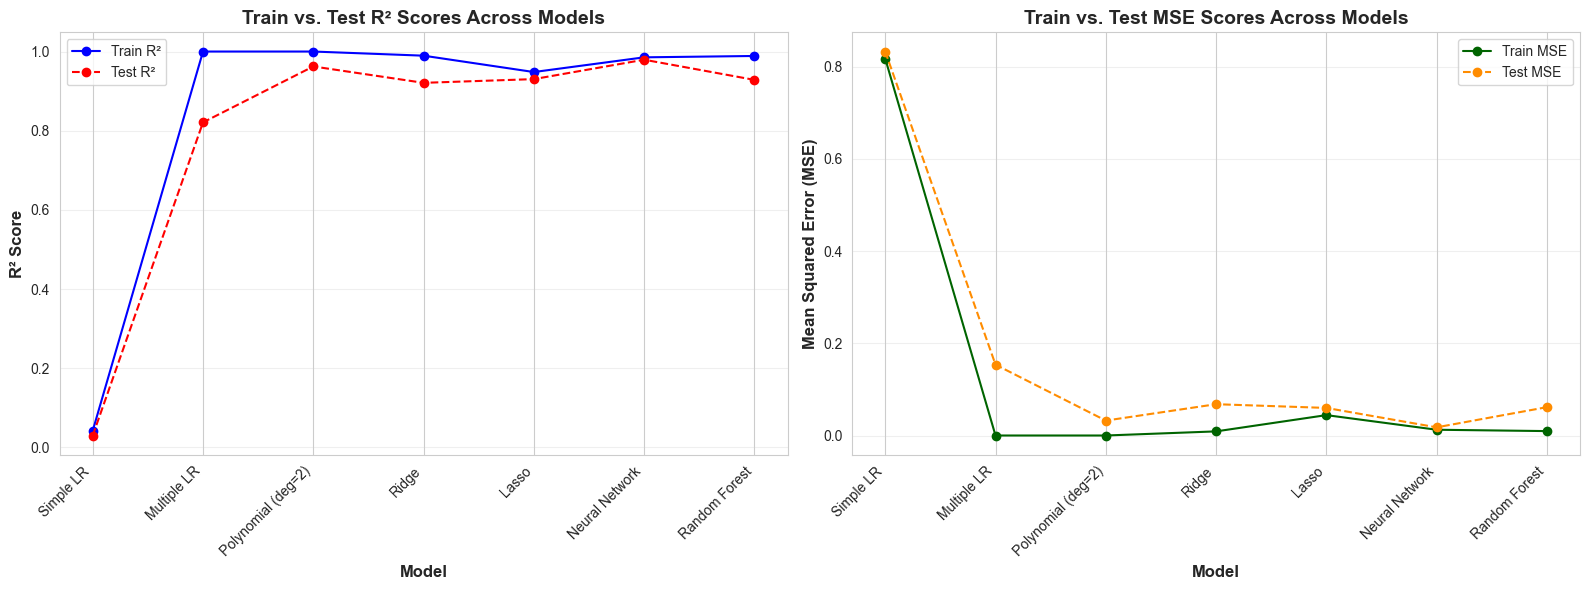

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# r2 Scores
axes[0].plot(comparison_df['Model'], comparison_df['Train R²'], marker='o', linestyle='-', label='Train R²', color='blue')
axes[0].plot(comparison_df['Model'], comparison_df['Test R²'], marker='o', linestyle='--', label='Test R²', color='red')
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Train vs. Test R² Scores Across Models', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(comparison_df['Model'])))
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# mse Scores
axes[1].plot(comparison_df['Model'], comparison_df['Train MSE'], marker='o', linestyle='-', label='Train MSE', color='darkgreen')
axes[1].plot(comparison_df['Model'], comparison_df['Test MSE'], marker='o', linestyle='--', label='Test MSE', color='darkorange')
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
axes[1].set_title('Train vs. Test MSE Scores Across Models', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(comparison_df['Model'])))
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()